In [26]:
import tensorflow as tf

In [27]:
import pandas as pd

In [28]:
import numpy as np

In [29]:
df = pd.read_excel('Cho_data.xlsx')

In [30]:
df.values[90:104]

array([['코스닥', 'IDX', 'I31000010F', ..., 693.56, 695.05, 694.18],
       ['코스닥', 'IDX', 'I31000020F', ..., 700.25, 697.25, 695.11],
       ['코스닥', 'IDX', 'I31000030F', ..., 677.5, 691.39, 680.68],
       ...,
       ['코스닥', 'IDX', 'I310020822', ..., 2941448000000, 2592576000000,
        2537219000000],
       ['코스닥', 'IDX', 'I310021112', ..., 405981000000, 375441000000,
        292013000000],
       ['코스닥', 'IDX', 'I310021122', ..., 412908000000, 351922000000,
        383067000000]], dtype=object)

코스닥 데이터 모으기

In [31]:
start_line = 90
end_line = 104
data_1 = (df.values[start_line:end_line,5:])

In [32]:
data_1 = data_1.astype(np.float)
data_1 = np.nan_to_num(data_1)

In [33]:
data_1

array([[2.583800e+03, 2.561600e+03, 2.670500e+03, ..., 6.935600e+02,
        6.950500e+02, 6.941800e+02],
       [2.682600e+03, 2.635800e+03, 2.684100e+03, ..., 7.002500e+02,
        6.972500e+02, 6.951100e+02],
       [2.528500e+03, 2.532300e+03, 2.396500e+03, ..., 6.775000e+02,
        6.913900e+02, 6.806800e+02],
       ...,
       [1.571859e+12, 1.914387e+12, 2.655116e+12, ..., 2.941448e+12,
        2.592576e+12, 2.537219e+12],
       [2.578200e+10, 3.121700e+10, 3.148700e+10, ..., 4.059810e+11,
        3.754410e+11, 2.920130e+11],
       [3.728300e+10, 3.355700e+10, 4.844300e+10, ..., 4.129080e+11,
        3.519220e+11, 3.830670e+11]])

In [34]:
import matplotlib.pyplot as plt

In [35]:
import matplotlib

In [36]:
%matplotlib inline

## 간단한 dynamic_rnn() 해보기

### 데이터 처리하는 방법 순서
- 상흠이가 준 데이터에서 시가, 고가, 저가, 종가, 수익률 등등 총 14개를 그냥 다 n_inputs 처리하기
- 각 데이터들 스케일이 다르기 때문에 normalization해줘야 함
- 각 데이터들이 총길이가 4656이기 때문에 200개의 연속된 데이터를 갖도록 랜덤하게 샘플링 해줌, 이게 n_samples 개수가 됨
- 얻어진 데이트들의 크기는 다음과 같아야 함. [n_samples, n_steps, n_inputs]

In [37]:
norm = np.linalg.norm(data_1, axis=1)

In [38]:
normalized_data = np.array([data_1[i] / norm[i] for i in range(len(data_1))])

In [39]:
np.linalg.norm(normalized_data,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [48]:
n_samples = 3000
n_steps = 300
n_inputs = 14
n_neurons = 200
n_outputs = 14
length_data = len(data_1[0])

In [49]:
#random_idx = np.sort(np.random.choice(length_data-n_steps-1, n_samples, replace=False))
## I think we don't need to sort for randomly shuffled train and test sets.
random_idx = np.random.choice(length_data-n_steps-1, n_samples, replace=False)

In [50]:
X_data = []
Y_data = []
for i in range(n_samples):
    temp_x = []
    temp_y = []
    for j in range(n_inputs):
        temp_x.append(normalized_data[j][random_idx[i]:random_idx[i]+n_steps])
        temp_y.append(normalized_data[j][random_idx[i]+1:random_idx[i]+n_steps+1])
    X_data.append(np.array(temp_x).T)
    Y_data.append(np.array(temp_y).T)
X_data = np.array(X_data)
Y_data = np.array(Y_data)

In [51]:
train_ratio = 0.8
size_train_set = int(n_samples*train_ratio) 
X_data_train = np.split(X_data, [size_train_set])[0]
Y_data_train = np.split(Y_data, [size_train_set])[0]
X_data_test = np.split(X_data, [size_train_set])[1]
Y_data_test = np.split(Y_data, [size_train_set])[1]

In [52]:
len(X_data_test)

600

In [53]:
fig = plt.figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

In [54]:
x = np.arange(1,len(data_1[0])+1)

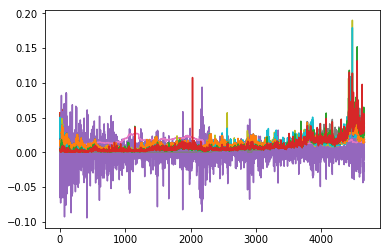

In [55]:
for i in range(len(data_1)):
    plt.plot(x, normalized_data[i])

### outputprojectionwrapper 이용해서 만들어보기

In [56]:
tf.reset_default_graph()

In [57]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
Y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [58]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [59]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [60]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - Y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [61]:
saver = tf.train.Saver()

In [62]:
def shuffle_batch(X, Y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], Y[batch_idx]
        yield X_batch, y_batch

In [63]:
n_iterations = 1500
batch_size = 200

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        for X_batch, y_batch in shuffle_batch(X_data_train, Y_data_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, Y: y_batch})
        if iteration % 100 == 0:
            mse_train = loss.eval(feed_dict={X: X_data_train, Y: Y_data_train})
            mse_test = loss.eval(feed_dict={X: X_data_test, Y: Y_data_test})
            print(iteration, "\tMSE_train:", mse_train, "\tMSE_test:", mse_test)
            saver.save(sess, "./my_singleRNN_model_kosdac") 

0 	MSE_train: 2.8825269e-05 	MSE_test: 2.8255596e-05
100 	MSE_train: 9.268372e-06 	MSE_test: 9.175193e-06
200 	MSE_train: 5.623914e-06 	MSE_test: 5.5449427e-06
300 	MSE_train: 4.90581e-06 	MSE_test: 4.8765537e-06
400 	MSE_train: 3.625595e-06 	MSE_test: 3.6326542e-06
500 	MSE_train: 3.1259449e-06 	MSE_test: 3.1717675e-06
600 	MSE_train: 2.9095768e-06 	MSE_test: 2.972372e-06
700 	MSE_train: 2.5886764e-06 	MSE_test: 2.6683492e-06
800 	MSE_train: 2.5710642e-06 	MSE_test: 2.655934e-06
900 	MSE_train: 2.269163e-06 	MSE_test: 2.3694474e-06
1000 	MSE_train: 2.1781007e-06 	MSE_test: 2.2823326e-06
1100 	MSE_train: 2.0170546e-06 	MSE_test: 2.1306587e-06
1200 	MSE_train: 1.948278e-06 	MSE_test: 2.0679847e-06
1300 	MSE_train: 1.7664902e-06 	MSE_test: 1.8913263e-06
1400 	MSE_train: 1.8609247e-06 	MSE_test: 1.9928382e-06


In [64]:
with tf.Session() as sess:                         
    saver.restore(sess, "./my_singleRNN_model_kosdac")   
    X_new = X_data_test[0].reshape(-1, n_steps, n_inputs)
    Y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_singleRNN_model_kosdac


In [65]:
draw_x = X_new.reshape(n_steps,n_inputs).T
draw_target = Y_data_test[0].T
draw_y = Y_pred.reshape(n_steps,n_inputs).T

In [66]:
len(draw_x)

14

In [67]:
x = np.arange(1,len(draw_x[0])+1)

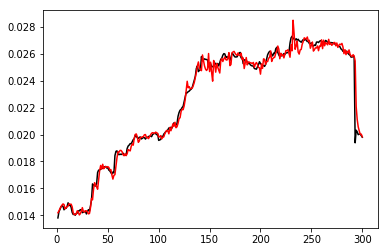

In [68]:
input_id = 6
#plt.plot(x, draw_x[input_id])
plt.plot(x, draw_target[input_id], color='black')
plt.plot(x, draw_y[input_id], color='red')

In [69]:
fig = plt.figure(figsize=(10,10))

<Figure size 720x720 with 0 Axes>

In [70]:
plt.rcParams['figure.figsize'] = [10, 10]

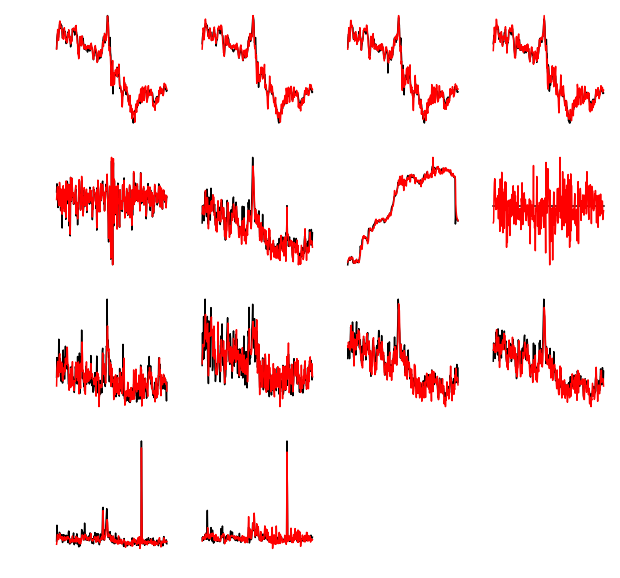

In [71]:
for i in range(n_inputs):
    plt.subplot(4,4,i+1)
    plt.plot(x, draw_target[i], color='black')
    plt.plot(x, draw_y[i], color='red')
    plt.axis('off')

In [76]:
with tf.Session() as sess:                         
    saver.restore(sess, "./my_singleRNN_model_kosdac")   
    X_test_all = X_data_test.reshape(-1, n_steps, n_inputs)
    Y_pred_test_all = sess.run(outputs, feed_dict={X: X_test_all})
    X_train_all = X_data_train.reshape(-1, n_steps, n_inputs)
    Y_pred_train_all = sess.run(outputs, feed_dict={X: X_train_all})  

INFO:tensorflow:Restoring parameters from ./my_singleRNN_model_kosdac


In [116]:
target_test_all = []
predic_test_all = []
target_train_all = []
predic_train_all = []

input_id = 4

for i in range(int(n_samples*train_ratio)):
    target_train_all.append(Y_data_train[i,-1,input_id] * norm[input_id])
    predic_train_all.append(Y_pred_train_all[i,-1,input_id]* norm[input_id])
for i in range(int(n_samples*(1.0-train_ratio))):
    target_test_all.append(Y_data_test[i,-1,input_id]* norm[input_id])
    predic_test_all.append(Y_pred_test_all[i,-1,input_id]* norm[input_id])

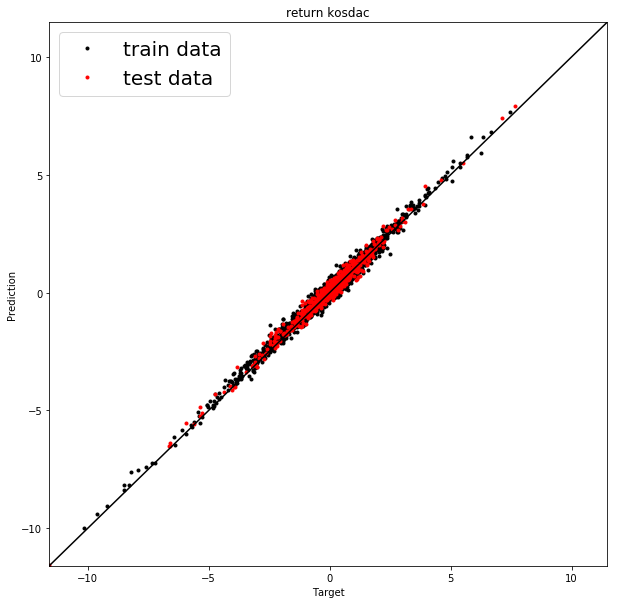

In [117]:
fig = plt.figure(figsize=(10,10))

x_min, x_max = min(min(target_train_all), min(target_test_all)), max(max(target_train_all), max(target_test_all))
plt.plot(target_train_all, predic_train_all, 'k.', label=r'train data')
plt.plot(target_test_all, predic_test_all, 'r.', label =r'test data')
plt.plot([x_min,x_max], [x_min,x_max], 'k-')
plt.legend(fontsize=20)
plt.ylim((x_min,x_max))
plt.xlim((x_min,x_max))
plt.title('return kosdac')
plt.xlabel('Target')
plt.ylabel('Prediction')
fig.savefig('test2.png')